In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse
from arch import arch_model

#from data_handler import get_sp500_ticker_list
from data_handler import get_adj_close
#from data_handler import sp500_closes_to_csv

In [2]:
# Getting the data
start='2018-01-01'
end='2020-12-31'
interval='1d'
ticker_list = 'AAPL'

df = get_adj_close(ticker_list, start, end, interval)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Computing returns
ret = 100 * df.pct_change()
ret.dropna(inplace=True)

In [4]:
# Computing realized volatility
realized_vol = ret.rolling(5).std()
realized_vol.dropna(inplace=True)

In [5]:
n = 252
split_date = ret.iloc[-n:].index

In [6]:
aic_gjr_garch = []

for p in range(1, 8): 
    for q in range(1, 8):
        gjr_garch = arch_model(ret, mean='zero', vol='GARCH', p=p, o=1, q=q)\
             .fit(disp='off') 
        aic_gjr_garch.append(gjr_garch.aic) 
    
        if gjr_garch.aic == np.min(aic_gjr_garch): 
             best_param = p, q # Finding the minimum AIC score
print(best_param)

(1, 1)


In [7]:
gjr_garch = arch_model(ret, mean='zero', vol='ARCH', p=best_param[0], o=1,
                       q=best_param[1]).fit(disp='off')

In [8]:
gjr_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -1638.24
Distribution:                  Normal   AIC:                           3280.48
Method:            Maximum Likelihood   BIC:                           3289.73
                                        No. Observations:                  754
Date:                Sun, May 01 2022   Df Residuals:                      754
Time:                        15:59:12   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.7605      0.457      8.221  2.013e-16   [  2.864,  4.657]
alpha[1]       0.2228  8.580e-02      2.596  9.419e-03 [5.461e-02,  0.391]
==========================================================================

Covariance estimator: robust
"""

In [9]:
forecast_gjr_garch = gjr_garch.forecast(start=split_date[0], reindex=True)

In [10]:
rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:]/100,
                        np.sqrt(forecast_gjr_garch.variance.iloc[-len(split_date):]/100)))
print('The RMSE value of GJR-GARCH model is {:.4f}'.format(rmse_gjr_garch))

The RMSE value of GJR-GARCH model is 0.2121


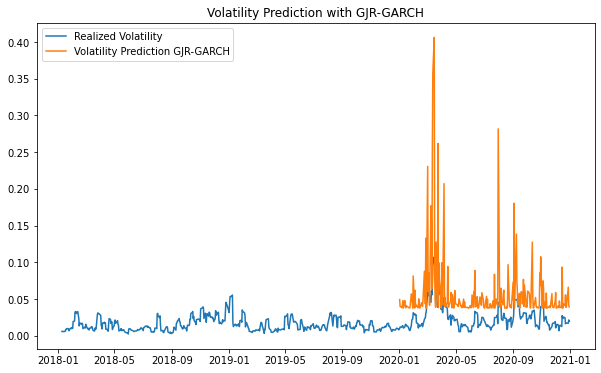

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjr_garch.variance.iloc[-len(split_date):] /100,
         label='Volatility Prediction GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()